<a href="https://colab.research.google.com/github/caio-olubini/Case---Especialista-de-Dados-Ecomm-/blob/main/Parte%202%20-%20An%C3%A1lise%20de%20Sentimento/Sentiment_Analysis_Products_Reviews_PT_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregando pacotes

In [ ]:
import pandas as pd
import time
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
try:
  from unidecode import unidecode
except ModuleNotFoundError:
  !pip install unidecode
  from unidecode import unidecode
from nltk.corpus import stopwords
import nltk
from scipy.stats import chi2_contingency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 13.2 MB/s eta 0:00:00


# Lendo datasets

In [ ]:
df_reviews = pd.read_csv('reviews.csv')
df_reviews.dropna(subset=['MSG_AVALIACAO'], inplace=True)
df_reviews['DT_HR_CRIACAO'] = pd.to_datetime(df_reviews['DT_HR_CRIACAO'], format='mixed')
df_reviews['COD_PEDIDO'] = df_reviews['COD_PEDIDO'].astype('Int64')

In [ ]:
df_sales = pd.read_csv('vendas.csv')
df_sales['DT_VENDA'] = pd.to_datetime(df_sales['DT_VENDA'])

# Análise exploratória

## Reviews

In [ ]:
df_reviews.sample(5)

,DT_HR_CRIACAO,COD_AVALIACAO,COD_PRODUTO,DES_PRODUTO,COD_PEDIDO,ESTADO_AVALIADOR,MSG_AVALIACAO,FLG_PRESENTE
4786,2025-03-07 12:00:29.871000+00:00,25beeb76-518a-46a2-8a36-947caca1e1a3,333,Creme Hidratante Depilatório Corporal Cuide-se...,<NA>,MG,"Mesmo seguindo as orientações da embalagem, ti...",False
335,2025-04-13 11:45:38.055000+00:00,62fa2ddc-2bd6-45ae-8ad2-dc16f5f6b61e,222,Floratta Red Desodorante Colônia 75ml,142754734,SP,Amei vc meu perfume preferido,False
2155,2025-02-23 18:17:56.823000+00:00,6b59fc3b-4832-40d6-b22c-3256bd36375e,333,Creme Hidratante Depilatório Corporal Cuide-se...,<NA>,SP,O cheiro lembra muito de creme para descolorir...,False
3606,2025-04-01 12:55:11.066000+00:00,3ef1b9cd-e344-4dea-8cd1-577faa217082,333,Creme Hidratante Depilatório Corporal Cuide-se...,145414542,RJ,Muito amor,False
1601,2025-04-14 08:42:57.193000+00:00,d817205b-a70f-475b-9c8e-edbe592b597e,222,Floratta Red Desodorante Colônia 75ml,<NA>,AL,Amei. Muito cheiroso!,False


/tmp/ipython-input-6-3521054209.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_reviews['month'] = df_reviews['DT_HR_CRIACAO'].dt.to_period('M')


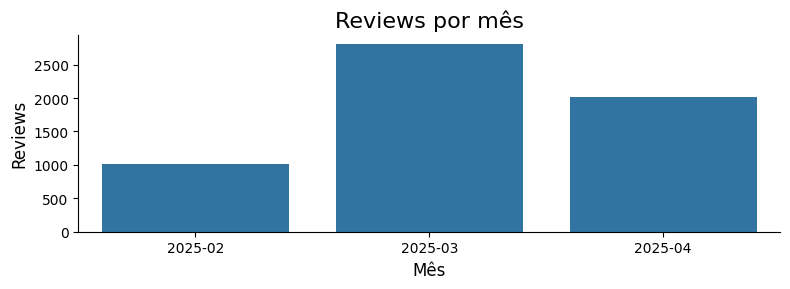

In [ ]:
# Extract month from the 'DT_HR_CRIACAO' column
df_reviews['month'] = df_reviews['DT_HR_CRIACAO'].dt.to_period('M')

# Group by month and count distinct COD_AVALIACAO
reviews_per_month = df_reviews.groupby('month')['COD_AVALIACAO'].nunique()

# Create the plot
plt.figure(figsize=(8, 3))
ax = sns.barplot(x=reviews_per_month.index.astype(str), y=reviews_per_month.values)
plt.title('Reviews por mês', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Reviews', fontsize=12)
plt.xticks(rotation=0)

sns.despine()
plt.tight_layout()

plt.show()

### Produtos

In [ ]:
df_reviews['COD_PRODUTO'].nunique()

3

In [ ]:
df_reviews[['COD_PRODUTO', 'DES_PRODUTO']].value_counts(normalize=True)

,,proportion
COD_PRODUTO,DES_PRODUTO,
222,Floratta Red Desodorante Colônia 75ml,0.696280
333,Creme Hidratante Depilatório Corporal Cuide-se Bem Doçura na Pessegura 150ml,0.216645
111,L'eau de Lily Desodorante Colônia 75ml,0.086915
333,Cuide-se Bem Doçura na Pessegura o Boticário - Creme Hidratante Depilatório Corporal 150ml,0.000160


O dataset contém reviews de apenas 3 produtos

Aparentemente temos uma atribuição errada da descrição **Cuide-se Bem Doçura na Pessegura o Boticário - Creme Hidratante Depilatório Corporal 150ml** para o código 333

### Mensagem de avaliação

In [ ]:
df_reviews['MSG_AVALIACAO'].nunique()

4865

In [ ]:
df_reviews['MSG_AVALIACAO'].value_counts()[:10]

,count
MSG_AVALIACAO,
Muito bom,89
Maravilhoso,87
Muito bom,77
Perfeito,58
Maravilhoso,57
Excelente,33
Ótimo,32
Muito bom!,27
Perfeito,26


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


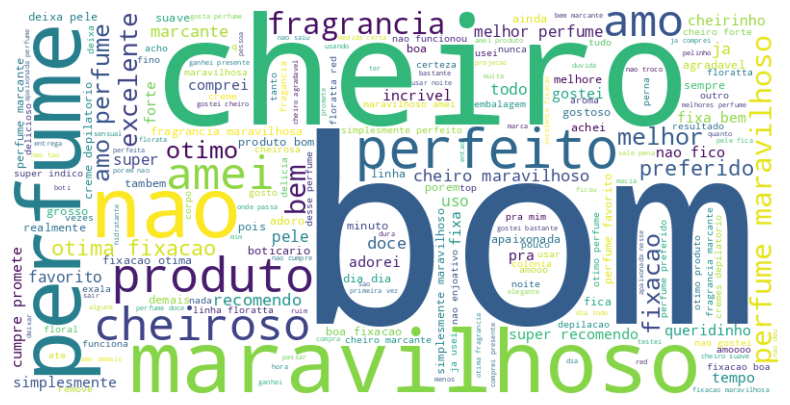

In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

# Function to preprocess text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Normalize special characters
    text = unidecode(text)
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# Combine all reviews into a single string and preprocess
text = " ".join(preprocess_text(review) for review in df_reviews['MSG_AVALIACAO'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Notamos que temos alguns reviews "repetidos" e mais comuns, majoriatariamente relacionados a mensagens curtas e positivas como "muito bom" ou "amei".

Analisando nossa nuvem de palavras notamos que a maioria dos comentários está relacionada a caracteristicas inerentes a categoria de perfumaria (cheiro, frangrancia,fixação) associadas a palavras positivas (maravilhoso, bom, perfeito)

### Flag presente

In [ ]:
df_reviews['FLG_PRESENTE'].value_counts(normalize = True)

,proportion
FLG_PRESENTE,
False,0.721213
True,0.278787


In [ ]:
df_reviews.groupby('COD_PRODUTO')['FLG_PRESENTE'].value_counts(normalize = True)

COD_PRODUTO  FLG_PRESENTE
111          False           0.660448
             True            0.339552
222          False           0.678463
             True            0.321537
333          False           0.883146
             True            0.116854
Name: proportion, dtype: float64

A maior parte dos comentários é referente a itens não presenteados.

O percentual presenteado do item 333 é consideravelmente menor dos que os demais, o que é esperado já que se trata de um hidratante.

### Estado (UF)

In [ ]:
df_reviews['ESTADO_AVALIADOR'].nunique()

27

In [ ]:
df_reviews['ESTADO_AVALIADOR'].value_counts(normalize=True)

,proportion
ESTADO_AVALIADOR,
SP,0.259857
MG,0.098208
RJ,0.086022
RS,0.066129
BA,0.061828
PR,0.057168
SC,0.049283
CE,0.036918
PE,0.033154


### Duplicicades

In [ ]:
df_reviews[df_reviews.drop(columns = ['DT_HR_CRIACAO']).duplicated(keep=False)]

,DT_HR_CRIACAO,COD_AVALIACAO,COD_PRODUTO,DES_PRODUTO,COD_PEDIDO,ESTADO_AVALIADOR,MSG_AVALIACAO,FLG_PRESENTE,month
0,2025-02-03 10:04:45.764000+00:00,2d561cc5-9811-48a6-a32e-787cfaae7ae9,222,Floratta Red Desodorante Colônia 75ml,144619615,GO,"Aroma agradável, embalagem bonita. Mas a proje...",False,2025-02
9,2025-02-09 20:43:22.511000+00:00,fb783a3f-701e-4399-a934-ccb038c459ef,333,Creme Hidratante Depilatório Corporal Cuide-se...,<NA>,PR,Muito bom,False,2025-02
16,2025-02-08 22:36:26.161000+00:00,a7fbb7e1-2da7-4ebf-bf49-402b9845c087,333,Creme Hidratante Depilatório Corporal Cuide-se...,<NA>,PR,"otimo produto, super recomendo..",False,2025-02
27,2025-02-09 22:02:33.561000+00:00,4abee43c-4982-436f-8889-3933fed096ea,111,L'eau de Lily Desodorante Colônia 75ml,<NA>,PR,Amei o produto,False,2025-02
28,2025-02-13 20:02:36.071000+00:00,83534934-d160-4b8e-90b9-22e3b9f5a93e,222,Floratta Red Desodorante Colônia 75ml,<NA>,PR,Cheiroso e com boa fixação.,False,2025-02
...,...,...,...,...,...,...,...,...,...
6116,2025-03-03 16:44:03.944000+00:00,06bcf1db-5c2e-417d-a4b8-979404ec5d93,222,Floratta Red Desodorante Colônia 75ml,142629091,RJ,Perfeito \nAmo muito 💕,False,2025-03
6117,2025-04-19 19:32:11.872000+00:00,8fc833a9-d210-458f-aaa0-a3c835a4864e,222,Floratta Red Desodorante Colônia 75ml,<NA>,SP,Perfume maravilhoso,False,2025-04
6118,2025-02-25 19:32:20.208000+00:00,cf792654-c3f6-4795-b7d5-cbe9d4dcd05e,333,Creme Hidratante Depilatório Corporal Cuide-se...,145383719,SP,"Amei , compraria novamente",False,2025-02
6119,2025-02-28 11:15:11.224000+00:00,1078a391-e6f3-494d-a2bb-579edb6c72d8,333,Creme Hidratante Depilatório Corporal Cuide-se...,<NA>,PR,"Péssimo produto, passei uma camada grossa sobr...",False,2025-02


**802 reviews duplicados** encontrados na base, provavelmente resultado de problemas no processo de coleta.

### Valores faltantes

In [ ]:
df_reviews.isna().sum()

,0
DT_HR_CRIACAO,0
COD_AVALIACAO,0
COD_PRODUTO,0
DES_PRODUTO,0
COD_PEDIDO,3589
ESTADO_AVALIADOR,656
MSG_AVALIACAO,0
FLG_PRESENTE,70
month,0


/tmp/ipython-input-18-3289749306.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_reviews['month'] = df_reviews['DT_HR_CRIACAO'].dt.to_period('M')


(0.0, 70.0)

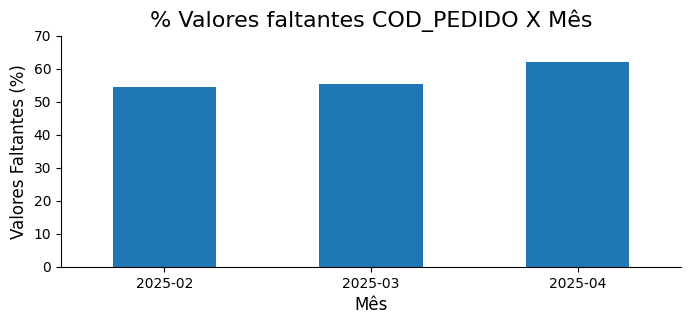

In [ ]:
# Extract month from the 'DT_HR_CRIACAO' column
df_reviews['month'] = df_reviews['DT_HR_CRIACAO'].dt.to_period('M')

# Calculate missing and total values per month
missing_per_month = df_reviews[df_reviews['COD_PEDIDO'].isna()].groupby('month').size()
total_per_month = df_reviews.groupby('month').size()

# Calculate the percentage of missing values
percentage_missing = (missing_per_month / total_per_month) * 100

# Plot the results
plt.figure(figsize=(8, 3))
ax = percentage_missing.plot(kind='bar')
plt.title('% Valores faltantes COD_PEDIDO X Mês', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Valores Faltantes (%)', fontsize=12)
plt.xticks(rotation=0)

# Remove top and right spines
sns.despine()

plt.ylim(0, 70)

**Valores faltantes:**

* COD_PEDIDO - aproximadamente metade dos registros não possuem o campo preenchido, o que deve afetar o cruzando com a base de vendas. O problema é um pouco mais acentuado no mês de Abril.

* ESTADO_AVALIADOR - 656 valores faltantes

* FLG_PRESENTE - 70

Pela restriçã de tempo e por entender que eles não necessariamente afetam o objetivo principal da análise, por hora não trataremos valores faltantes.

In [ ]:
df_sales = pd.read_csv('vendas.csv')
df_sales

,DT_VENDA,COD_PEDIDO,DES_CANAL_VENDA_FINAL,COD_MATERIAL,DES_MATERIAL,VLR_RECEITA_CAPTADA
0,2025-03-20,146375997,App,222,FLORATTA DES COL RED 75ML,1144.723000
1,2025-03-28,146571073,Site,222,FLORATTA DES COL RED 75ML,1144.723000
2,2025-03-05,145824498,Site,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,332.912796
3,2025-02-10,145319819,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,280.854400
4,2025-04-08,146841380,Site,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,336.643000
...,...,...,...,...,...,...
30010,2025-03-02,148559264,Mktp Out,333,Creme Hidratante Depilatório Corporal Cuide-se...,320.327446
30011,2025-03-04,151546850,Mktp Out,222,Floratta Red Desodorante Colônia 75ml,1149.115580
30012,2025-03-02,157699934,Mktp Out,222,Floratta Red Desodorante Colônia 75ml,1156.885580
30013,2025-03-07,154953808,Mktp Out,222,Floratta Red Desodorante Colônia 75ml,1133.575580


In [ ]:
df_sales['COD_PEDIDO'].nunique()

29792

## Vendas

In [ ]:
df_sales.sample(5)

,DT_VENDA,COD_PEDIDO,DES_CANAL_VENDA_FINAL,COD_MATERIAL,DES_MATERIAL,VLR_RECEITA_CAPTADA
19400,2025-02-10,145315633,Site,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,537.886000
5680,2025-03-19,146331735,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,1049.929000
23534,2025-02-13,145402379,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,258.943000
19622,2025-04-30,147371909,App,222,FLORATTA DES COL RED 75ML,940.598757
17185,2025-02-07,145219753,Site,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,175.260100


In [ ]:
df_sales[['DT_VENDA', 'VLR_RECEITA_CAPTADA']].describe()

,VLR_RECEITA_CAPTADA
count,30015.000000
mean,698.737996
std,519.127677
min,87.126230
25%,258.943000
50%,389.789800
75%,1144.723000
max,8134.615000


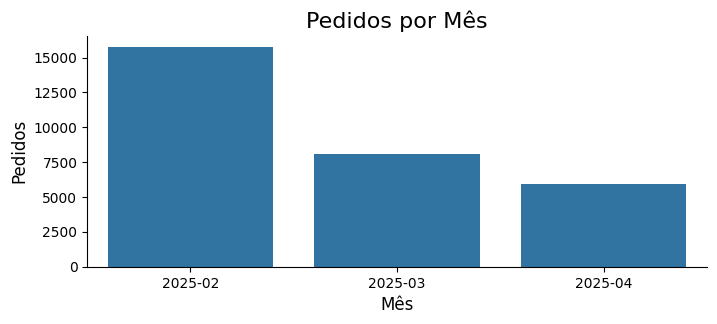

In [ ]:
# Extract month from the 'DT_VENDA' column
df_sales['month'] = pd.to_datetime(df_sales['DT_VENDA']).dt.to_period('M')

# Group by month and count distinct COD_PEDIDO
sales_per_month = df_sales.groupby('month')['COD_PEDIDO'].nunique()

# Create the plot
plt.figure(figsize=(8, 3))
ax = sns.barplot(x=sales_per_month.index.astype(str), y=sales_per_month.values)
plt.title('Pedidos por Mês', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Pedidos', fontsize=12)
plt.xticks(rotation=0)

# Remove top and right spines
sns.despine()


plt.show()

### Canal de venda (APP, SITE, MKTP)

In [ ]:
df_sales['DES_CANAL_VENDA_FINAL'].value_counts(normalize=True)

,proportion
DES_CANAL_VENDA_FINAL,
App,0.775979
Site,0.196368
Mktp Out,0.018891
Mktp In,0.008762


In [ ]:
df_sales.groupby('DES_CANAL_VENDA_FINAL')['VLR_RECEITA_CAPTADA'].mean()

,VLR_RECEITA_CAPTADA
DES_CANAL_VENDA_FINAL,
App,685.154848
Mktp In,741.698976
Mktp Out,1026.616449
Site,718.955044


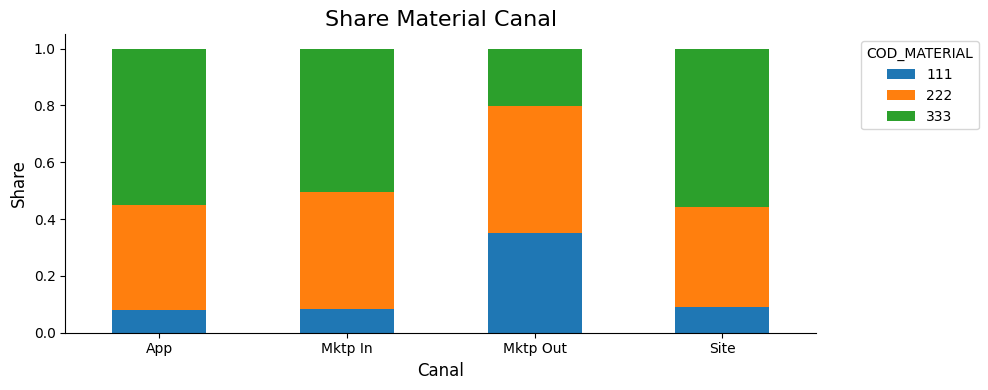

In [ ]:
# Calculate the percentage of each COD_MATERIAL within each DES_CANAL_VENDA_FINAL
share_by_channel = df_sales.groupby(['DES_CANAL_VENDA_FINAL', 'COD_MATERIAL']).size().unstack(fill_value=0)
share_by_channel = share_by_channel.apply(lambda x: x / x.sum(), axis=1)

# Plot the results as a stacked bar chart
share_by_channel.plot(kind='bar', stacked=True, figsize=(10, 4))

plt.title('Share Material Canal', fontsize=16)
plt.xlabel('Canal', fontsize=12)
plt.ylabel('Share', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='COD_MATERIAL', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

O dataset possui 4 canais de venda:

App, Site, Mktp In, Mktp Out

Tendo app a maior representação de pedidos e Mktp Out o melhor ticket médio.

### Produtos

In [ ]:
df_sales['COD_MATERIAL'].nunique()

3

In [ ]:
df_sales[['COD_MATERIAL', 'DES_MATERIAL']].value_counts(normalize=True)

,,proportion
COD_MATERIAL,DES_MATERIAL,
333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,0.544694
222,FLORATTA DES COL RED 75ML,0.366550
111,LILY DES COL LEAU DE 75ML,0.088256
222,Floratta Red Desodorante Colônia 75ml,0.000267
333,Creme Hidratante Depilatório Corporal Cuide-se Bem Doçura na Pessegura 150ml,0.000200
111,L'eau de Lily Desodorante Colônia 75ml,0.000033


In [ ]:
df_sales.groupby('COD_MATERIAL')['VLR_RECEITA_CAPTADA'].describe()

,count,mean,std,min,25%,50%,75%,max
COD_MATERIAL,,,,,,,,
111,2650.0,1451.521957,415.974141,281.610372,1338.97300,1402.578625,1610.922999,8134.615
222,11010.0,1125.821106,323.750173,501.833200,1004.94070,1144.723000,1144.723000,5803.615
333,16355.0,289.256948,117.048580,87.126230,247.27004,258.943000,311.793068,1763.215


/tmp/ipython-input-30-907063187.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='COD_MATERIAL', y='VLR_RECEITA_CAPTADA', data=df_sales, palette='viridis')


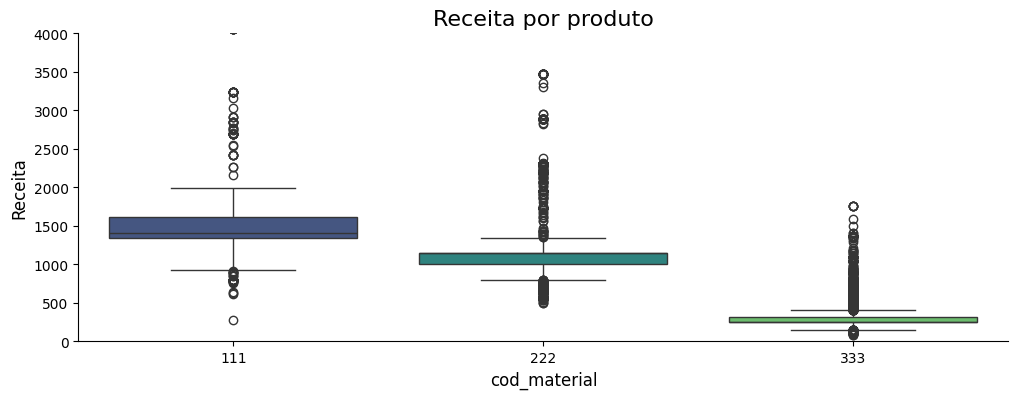

In [ ]:
plt.figure(figsize=(12, 4))
sns.boxplot(x='COD_MATERIAL', y='VLR_RECEITA_CAPTADA', data=df_sales, palette='viridis')
plt.title('Receita por produto', fontsize=16)
plt.xlabel('cod_material', fontsize=12)
plt.ylabel('Receita', fontsize=12)
sns.despine()
plt.ylim(0, 4000)
plt.show()

Aqui temos os mesmos três produtos observados na base de reviews, porém, com shares invertidos, o que pode indicar que diferentes materiais tem maior ou menor propensão a serem avaliados.

Podemos notar que o mesmo produto pode possuir valores de receita associada bastante variados!!

Novamente, vemos também observamos erros de atribuição de cod_material.

### Receita

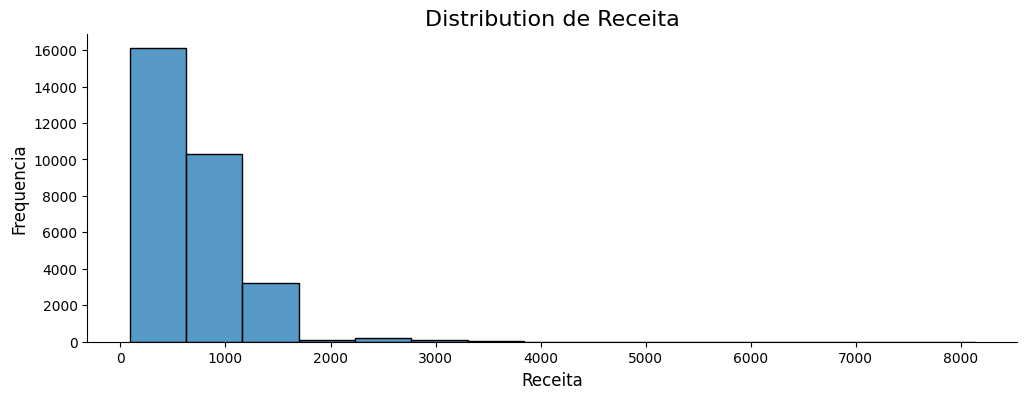

In [ ]:
plt.figure(figsize=(12, 4))
sns.histplot(df_sales['VLR_RECEITA_CAPTADA'], bins=15)
plt.title('Distribution de Receita', fontsize=16)
plt.xlabel('Receita', fontsize=12)
plt.ylabel('Frequencia', fontsize=12)
sns.despine()
plt.show()

/tmp/ipython-input-32-2468209578.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DES_CANAL_VENDA_FINAL', y='VLR_RECEITA_CAPTADA', data=df_sales, palette='viridis')


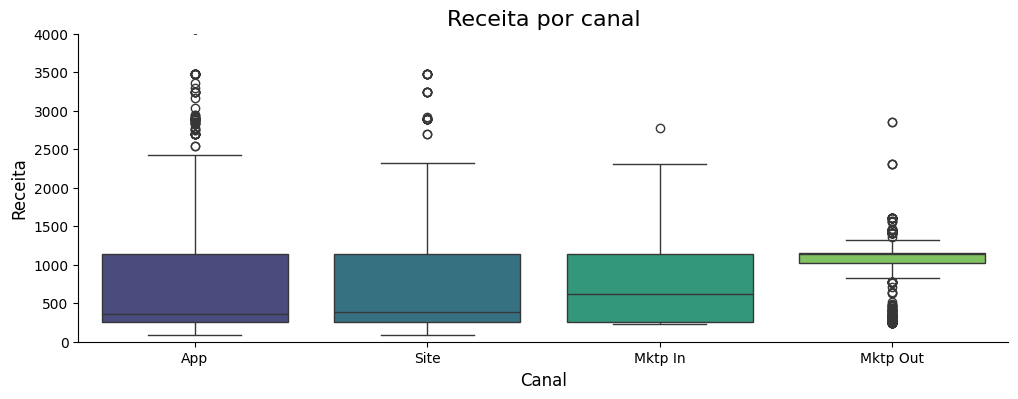

In [ ]:
plt.figure(figsize=(12, 4))
sns.boxplot(x='DES_CANAL_VENDA_FINAL', y='VLR_RECEITA_CAPTADA', data=df_sales, palette='viridis')
plt.title('Receita por canal', fontsize=16)
plt.xlabel('Canal', fontsize=12)
plt.ylabel('Receita', fontsize=12)
sns.despine()
plt.ylim(0, 4000)
plt.show()

75% das vendas tem valor de até 1000 reais.

App e Site tem distribuições de receita muito parecidas.

Mktp In tem uma tendência central um pouco mais elevada.

Mkt Out possui distribuição bastante distinta, com valores de receita mais elevados.

### Duplicidades

In [ ]:
df_sales[df_sales.duplicated(subset = ['COD_PEDIDO'], keep=False)]

,DT_VENDA,COD_PEDIDO,DES_CANAL_VENDA_FINAL,COD_MATERIAL,DES_MATERIAL,VLR_RECEITA_CAPTADA,month
9,2025-03-11,146030782,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,336.643000,2025-03
74,2025-02-22,145595957,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,258.943000,2025-02
85,2025-02-22,145602949,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,258.943000,2025-02
117,2025-03-04,145809706,Site,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,300.978700,2025-03
152,2025-03-08,145907520,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,327.761959,2025-03
...,...,...,...,...,...,...,...
29851,2025-02-19,145525649,App,111,LILY DES COL LEAU DE 75ML,1378.125293,2025-02
29892,2025-03-01,145748248,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,258.943000,2025-03
29912,2025-03-12,146059902,App,222,FLORATTA DES COL RED 75ML,1144.723000,2025-03
29961,2025-02-27,145710623,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,258.943000,2025-02


In [ ]:
df_sales[df_sales.duplicated(subset = ['COD_PEDIDO', 'COD_MATERIAL'], keep=False)]

,DT_VENDA,COD_PEDIDO,DES_CANAL_VENDA_FINAL,COD_MATERIAL,DES_MATERIAL,VLR_RECEITA_CAPTADA,month
85,2025-02-22,145602949,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,258.943000,2025-02
152,2025-03-08,145907520,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,327.761959,2025-03
201,2025-04-02,146702257,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,260.193519,2025-04
335,2025-02-24,145632247,App,222,FLORATTA DES COL RED 75ML,1144.723000,2025-02
424,2025-02-24,145642426,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,287.070400,2025-02
...,...,...,...,...,...,...,...
28571,2025-02-18,145510340,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,258.943000,2025-02
29039,2025-02-24,145632247,App,222,FLORATTA DES COL RED 75ML,1144.723001,2025-02
29271,2025-02-12,145362241,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,537.886000,2025-02
29649,2025-03-05,145819170,App,333,CBEM CR HID CPO DEPIL DOC/PESSEGUR 150ML,279.415100,2025-03


No dataset de vendas temos duplicidades a nível de cod_pedido e material, nesse caso optaremos por agrupar a nível de pedido e SKU, somando a receita captada.

### Valores faltantes

In [ ]:
df_sales.isna().sum()

,0
DT_VENDA,0
COD_PEDIDO,0
DES_CANAL_VENDA_FINAL,0
COD_MATERIAL,0
DES_MATERIAL,0
VLR_RECEITA_CAPTADA,0
month,0


# Pré-processamento e Engenharia de recursos

## Duplicidade

In [ ]:
rows_to_drop = df_reviews.drop(columns = ['DT_HR_CRIACAO']).duplicated(keep=False)
df_reviews = df_reviews[~rows_to_drop]
df_reviews

,DT_HR_CRIACAO,COD_AVALIACAO,COD_PRODUTO,DES_PRODUTO,COD_PEDIDO,ESTADO_AVALIADOR,MSG_AVALIACAO,FLG_PRESENTE,month
1,2025-02-10 07:00:42.130000+00:00,7e632886-12c5-4045-9e4a-bef933c0660d,222,Floratta Red Desodorante Colônia 75ml,142381882,PR,"Muito bom, ótima fixação",False,2025-02
2,2025-02-10 14:51:12.232000+00:00,f9be0409-8cd8-4e31-a46a-3a743367d25b,222,Floratta Red Desodorante Colônia 75ml,<NA>,CE,"Um bom perfume, não sinto que fixa muito mas é...",False,2025-02
3,2025-02-10 00:39:33.142000+00:00,3d3c3439-73c9-40f0-a498-d8287bf9fbed,222,Floratta Red Desodorante Colônia 75ml,<NA>,PR,"Um dos meus perfumes favoritos do boti, ótima ...",True,2025-02
4,2025-02-10 10:37:24.373000+00:00,fe1c6e98-e605-4a44-9011-16b600537a18,222,Floratta Red Desodorante Colônia 75ml,<NA>,CE,Muito bom,False,2025-02
5,2025-02-10 13:29:47.233000+00:00,39292335-fa28-4ed5-ae98-69feadf82a1e,222,Floratta Red Desodorante Colônia 75ml,<NA>,PI,Perfeito,False,2025-02
...,...,...,...,...,...,...,...,...,...
6231,2025-04-06 04:12:59.286078+00:00,16240007-11a9-437c-bd96-1251928e6f18,222,Floratta Red Desodorante Colônia 75ml,158483855,ES,A caixa do kit estava aberta e com um panfleto...,True,2025-04
6232,2025-04-02 20:53:00.176682+00:00,ada764f3-8f52-40e9-945d-a5e22dcc63b8,222,Floratta Red Desodorante Colônia 75ml,158483017,AM,"Veio toda rasgada, decepção define",True,2025-04
6233,2025-04-04 20:22:39.895277+00:00,c9cc885e-f170-40e4-89d2-e6a35f14abe9,222,Floratta Red Desodorante Colônia 75ml,158483652,RJ,"Embalagem amassada e suja de cola, péssimo aca...",True,2025-04
6234,2025-04-01 11:09:51.483045+00:00,76fd33ba-8f5d-4dcd-a0ea-a27c413e4ca9,222,Floratta Red Desodorante Colônia 75ml,158481665,GO,A caixa chegou aberta e com um folheto de outr...,True,2025-04


In [ ]:
df_sales = df_sales.groupby(['COD_PEDIDO', 'COD_MATERIAL', 'DES_CANAL_VENDA_FINAL']).agg({'VLR_RECEITA_CAPTADA': 'sum', 'DT_VENDA': 'min'}).reset_index()
df_sales

,COD_PEDIDO,COD_MATERIAL,DES_CANAL_VENDA_FINAL,VLR_RECEITA_CAPTADA,DT_VENDA
0,145038302,222,App,1144.723000,2025-02-01
1,145038342,222,App,1131.457172,2025-02-01
2,145039463,222,App,1144.723000,2025-02-01
3,145039527,222,App,1046.790759,2025-02-01
4,145040632,111,Site,1388.686612,2025-02-01
...,...,...,...,...,...
29932,154953808,222,Mktp Out,1133.575580,2025-03-07
29933,156374922,333,Mktp Out,312.557446,2025-03-02
29934,157699934,222,Mktp Out,1156.885580,2025-03-02
29935,158239079,222,Mktp Out,1141.345580,2025-03-06


## Cruzamento de bases

In [ ]:
df_reviews_merged = pd.merge(df_reviews, df_sales[['COD_PEDIDO', 'COD_MATERIAL', 'DES_CANAL_VENDA_FINAL', 'VLR_RECEITA_CAPTADA', 'DT_VENDA']], how = 'left', left_on = ['COD_PEDIDO', 'COD_PRODUTO'], right_on = ['COD_PEDIDO', 'COD_MATERIAL']).drop(columns = ['COD_MATERIAL'])
df_reviews_merged.sample(5)

,DT_HR_CRIACAO,COD_AVALIACAO,COD_PRODUTO,DES_PRODUTO,COD_PEDIDO,ESTADO_AVALIADOR,MSG_AVALIACAO,FLG_PRESENTE,month,DES_CANAL_VENDA_FINAL,VLR_RECEITA_CAPTADA,DT_VENDA
1803,2025-03-31 08:23:53.264000+00:00,c77a286a-22f8-433e-8ec9-9dcf38415973,222,Floratta Red Desodorante Colônia 75ml,<NA>,SC,"Maravilhoso, recomendo.",True,2025-03,NaN,NaN,NaN
4023,2025-03-11 13:39:23.662000+00:00,387501f3-ea0c-4213-9113-f341dc9e01ba,222,Floratta Red Desodorante Colônia 75ml,145628768,MG,Ele é maravilhoso,False,2025-03,Site,1144.723,2025-02-24
4112,2025-03-06 22:53:24.105000+00:00,9b0e4cd2-8977-44a7-b903-1acf95852f80,222,Floratta Red Desodorante Colônia 75ml,142688461,SP,"Eu gosto muito desse perfume, tenho o body spl...",False,2025-03,NaN,NaN,NaN
2153,2025-04-22 17:37:04.470000+00:00,b529f107-fa7b-4c26-9510-3a05d31b0369,222,Floratta Red Desodorante Colônia 75ml,<NA>,PR,Já usei 2 frascos deste Desodorante Colônia. E...,False,2025-04,NaN,NaN,NaN
2790,2025-04-21 02:19:20.278000+00:00,360e280e-5a03-4014-9cf8-7b78b800ee09,222,Floratta Red Desodorante Colônia 75ml,<NA>,PB,muito bom o cheiro 😍,True,2025-04,NaN,NaN,NaN


In [ ]:
df_reviews_merged.isna().mean()

,0
DT_HR_CRIACAO,0.000000
COD_AVALIACAO,0.000000
COD_PRODUTO,0.000000
DES_PRODUTO,0.000000
COD_PEDIDO,0.571770
ESTADO_AVALIADOR,0.104159
MSG_AVALIACAO,0.000000
FLG_PRESENTE,0.011778
month,0.000000
DES_CANAL_VENDA_FINAL,0.871550


Como somente 13% dos reviews tem correspondência na base de vendas, a partir desse ponto seguiremos a análise desconsiderando dados cruzados.

Trazer análises a partir desses dados agregaria viés aos nossos resultados, já que provavelmente existe um motivo sistemático para que certos comentários não tenham correspondência.


## Criação de recursos - Região

In [ ]:
# Define the mapping from state to region
region_map = {
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# Create the new 'REGIAO_AVALIADOR' column
df_reviews['REGIAO_AVALIADOR'] = df_reviews['ESTADO_AVALIADOR'].map(region_map)

# Display the first few rows with the new column
df_reviews[['ESTADO_AVALIADOR', 'REGIAO_AVALIADOR']].sample(5)

,ESTADO_AVALIADOR,REGIAO_AVALIADOR
4457,GO,Centro-Oeste
6166,NaN,NaN
4171,RJ,Sudeste
1780,AL,Nordeste
4750,RS,Sul


/tmp/ipython-input-41-1432693203.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=reviews_by_region.index, y=reviews_by_region.values, palette='viridis')


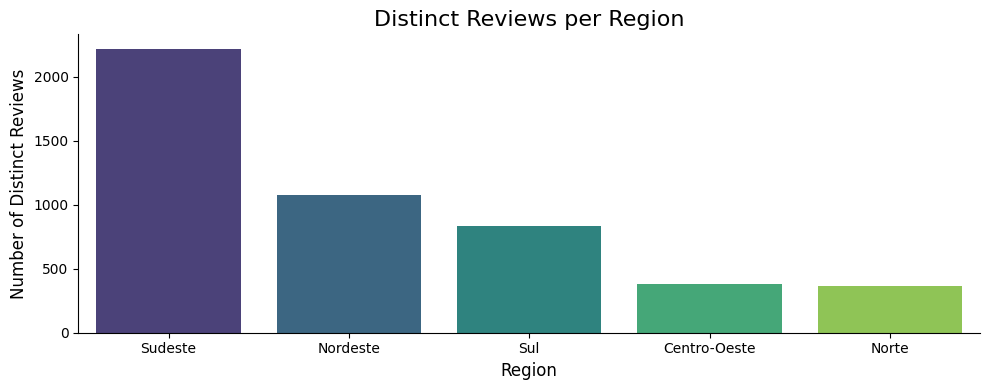

In [ ]:
# Group by region and count distinct reviews
reviews_by_region = df_reviews.groupby('REGIAO_AVALIADOR')['COD_AVALIACAO'].nunique().sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(10, 4))
ax = sns.barplot(x=reviews_by_region.index, y=reviews_by_region.values, palette='viridis')

# Add titles and labels
plt.title('Distinct Reviews per Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Number of Distinct Reviews', fontsize=12)
plt.xticks(rotation=0)

# Clean up the plot
sns.despine()
plt.tight_layout()
plt.show()

# Modelagem

Nesta seção, realizaremos a análise de sentimentos dos dados. Para isso, utilizaremos a função pipeline da biblioteca **Hugging Face**, uma ferramenta de alto nível que simplifica todo o processo de modelagem.

O modelo escolhido é o **bertweet-pt-sentiment**, que foi treinado especificamente com um vocabulário em português e é otimizado para a tarefa de análise de sentimentos.

In [ ]:
print("Carregando o modelo pré-treinado 'pysentimiento/bertweet-pt-sentiment'...")
try:
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="pysentimiento/bertweet-pt-sentiment",
        device = 0
    )
    print("✅ Modelo carregado com sucesso!")
except Exception as e:
    print(f"Ocorreu um erro ao carregar o modelo: {e}")

Carregando o modelo pré-treinado 'pysentimiento/bertweet-pt-sentiment'...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


✅ Modelo carregado com sucesso!


In [ ]:
df_reviews = pd.read_csv('reviews_classificados.csv')
df_reviews['DT_HR_CRIACAO'] = pd.to_datetime(df_reviews['DT_HR_CRIACAO'], format='mixed')
df_reviews['COD_PEDIDO'] = df_reviews['COD_PEDIDO'].astype('Int64')

'''reviews = df_reviews['MSG_AVALIACAO'].tolist()

print(f"\nIniciando a classificação de {len(reviews)} textos em lote...")
start_time = time.time()
classification_results = sentiment_pipeline(reviews, truncation=True, batch_size=8)
end_time = time.time()
print("✅ Classificação em lote concluída!")

elapsed_time = end_time - start_time
print(f"Tempo de execução: {elapsed_time:.2f} segundos")

labels = [r['label'].capitalize() for r in classification_results]
df_reviews['labels'] = labels'''

# Tempo de execução: 716.51 segundos -- Sem GPU


'reviews = df_reviews[\'MSG_AVALIACAO\'].tolist()\n\nprint(f"\nIniciando a classificação de {len(reviews)} textos em lote...")\nstart_time = time.time()\nclassification_results = sentiment_pipeline(reviews, truncation=True, batch_size=8)\nend_time = time.time()\nprint("✅ Classificação em lote concluída!")\n\nelapsed_time = end_time - start_time\nprint(f"Tempo de execução: {elapsed_time:.2f} segundos")\n\nlabels = [r[\'label\'].capitalize() for r in classification_results]\ndf_reviews[\'labels\'] = labels'

In [ ]:
df_reviews.to_csv('reviews_classificados.csv', index = False)

## Fluxo em produção

## Avaliação do modelo

# Insights

# Análise de Sentimento


In [ ]:
df_reviews['labels'].value_counts(normalize = True)

,proportion
labels,
Pos,0.869341
Neg,0.065329
Neu,0.065329


## Sentimento ao longo do tempo

In [ ]:
df_reviews.groupby(['month'])['labels'].value_counts(normalize = True)


month    labels
2025-02  Pos       0.821086
         Neg       0.102236
         Neu       0.076677
2025-03  Pos       0.885878
         Neu       0.064122
         Neg       0.050000
2025-04  Pos       0.870400
         Neg       0.068267
         Neu       0.061333
Name: proportion, dtype: float64

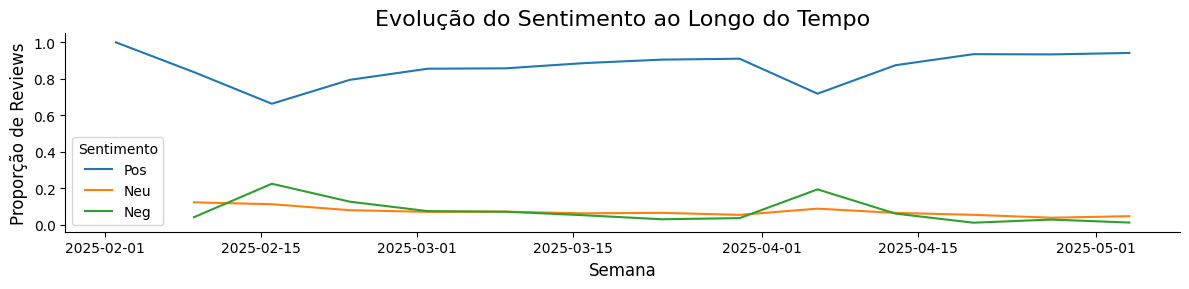

In [ ]:
# Group by month and sentiment, then count occurrences
sentiment_over_time = df_reviews.groupby(pd.Grouper(key='DT_HR_CRIACAO', freq='W'))['labels'].value_counts(normalize = True).reset_index()

# Plot the sentiment trends over time
plt.figure(figsize=(12, 3))
sns.lineplot(data = sentiment_over_time, x = 'DT_HR_CRIACAO', y = 'proportion', hue = 'labels')

# Add titles and labels
plt.title('Evolução do Sentimento ao Longo do Tempo', fontsize=16)
plt.xlabel('Semana', fontsize=12)
plt.ylabel('Proporção de Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentimento')
sns.despine()
plt.tight_layout()
plt.show()

## Sentimento por produto

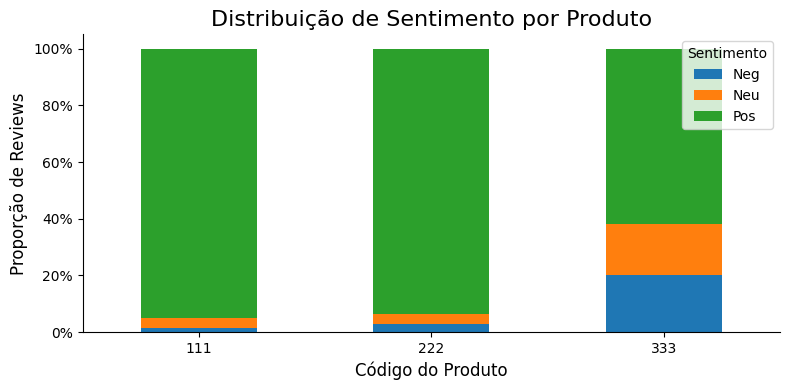

In [ ]:
# Group by product and sentiment, then count occurrences
sentiment_by_product = df_reviews.groupby(['COD_PRODUTO', 'labels']).size().unstack(fill_value=0)

# Normalize to get percentages
sentiment_by_product_percentage = sentiment_by_product.div(sentiment_by_product.sum(axis=1), axis=0)

# Create a 100% stacked bar chart
ax = sentiment_by_product_percentage.plot(kind='bar', stacked=True, figsize=(8, 4))

# Add titles and labels
plt.title('Distribuição de Sentimento por Produto', fontsize=16)
plt.xlabel('Código do Produto', fontsize=12)
plt.ylabel('Proporção de Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentimento')

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Clean up the plot
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(df_reviews['COD_PRODUTO'], df_reviews['labels'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-Square Test for COD_PRODUTO vs labels")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("\nConclusion: There is a statistically significant association between product and sentiment (p < 0.05).")
else:
    print("\nConclusion: There is no statistically significant association between product and sentiment (p >= 0.05).")

Chi-Square Test for COD_PRODUTO vs labels
Chi-Square Statistic: 819.6155569488948
P-value: 4.32894258425895e-176
Degrees of Freedom: 4

Conclusion: There is a statistically significant association between product and sentiment (p < 0.05).


### Ao longo do tempo

In [ ]:
df_reviews.groupby(['COD_PRODUTO', 'month'])['labels'].value_counts(normalize = True)

COD_PRODUTO  month    labels
111          2025-02  Pos       0.948052
                      Neg       0.025974
                      Neu       0.025974
             2025-03  Pos       0.949367
                      Neu       0.029536
                      Neg       0.021097
             2025-04  Pos       0.956250
                      Neu       0.043750
222          2025-02  Pos       0.963462
                      Neu       0.023077
                      Neg       0.013462
             2025-03  Pos       0.962534
                      Neu       0.029752
                      Neg       0.007713
             2025-04  Pos       0.892003
                      Neg       0.062884
                      Neu       0.045113
333          2025-02  Pos       0.576023
                      Neg       0.254386
                      Neu       0.169591
             2025-03  Pos       0.614437
                      Neg       0.197183
                      Neu       0.188380
             2025-04  Pos       0.690476
                      Neu       0.166667
                      Neg       0.142857
Name: proportion, dtype: float64

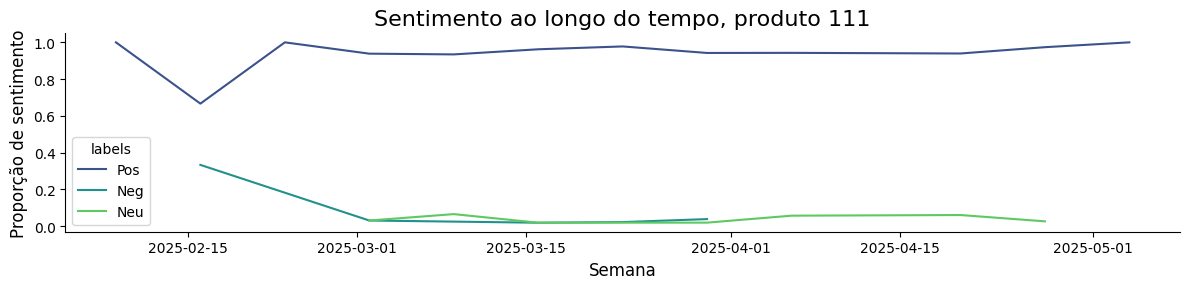

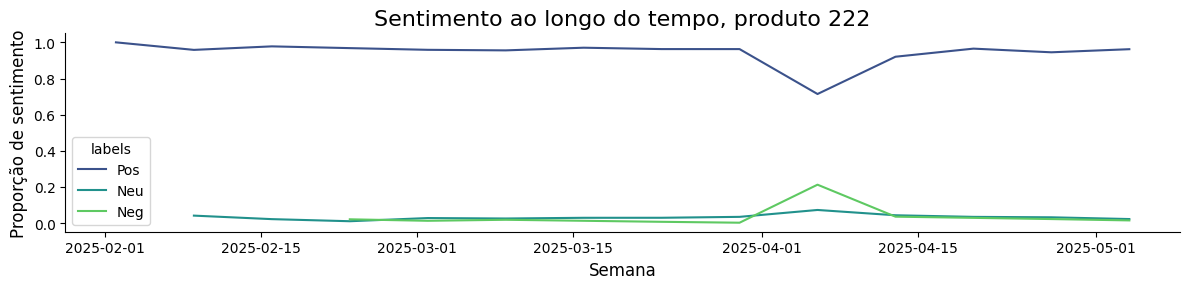

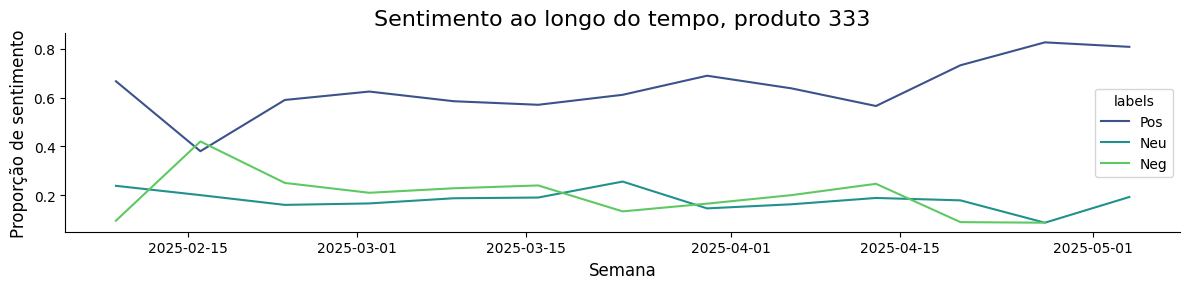

In [ ]:
for produto in sorted(df_reviews['COD_PRODUTO'].unique()):

  product_reviews = df_reviews[df_reviews['COD_PRODUTO'] == produto]

  g = product_reviews.groupby(pd.Grouper(key='DT_HR_CRIACAO', freq='W'))['labels'].value_counts(normalize = True).reset_index()

  plt.figure(figsize=(12, 3))
  plt.title(f'Sentimento ao longo do tempo, produto {produto}', fontsize=16)
  plt.xlabel('Semana', fontsize=12)
  plt.ylabel('Proporção de sentimento', fontsize=12)
  sns.lineplot(data=g, x='DT_HR_CRIACAO', y='proportion', hue='labels', palette='viridis')

  sns.despine()
  plt.tight_layout()
  plt.show()

### Deepdive comentários negativos 333

In [ ]:
df_reviews[(df_reviews['COD_PRODUTO'] == 333) & (df_reviews['month'] == '2025-02') & (df_reviews['labels'] == 'Neg')]['MSG_AVALIACAO'].head(10)

,MSG_AVALIACAO
77,"Não entrega o que promete, não tem siquer o ch..."
80,Tive que esperar uns 16 minutos para ver o res...
97,Estou fazendo depilação a laser e pensei em us...
98,"Comprei o produto hoje, e hoje mesmo já utiliz..."
138,Pior produto que ja comprei! Não tira pelo nen...
140,Usei o produto 2x e achei extremamente fraco. ...
142,Nao tirou um pelo sequer da perna e na axila t...
146,"Pelo menos para a minha pele, não funcionou na..."
152,"Não cumpre o q promete, nao tirou nd de pelos ..."
161,Produto pessimo!! Não indico pra quem tem pelo...


In [ ]:
df_reviews[(df_reviews['COD_PRODUTO'] == 333) & (df_reviews['month'] == '2025-04') & (df_reviews['labels'] == 'Neg')]['MSG_AVALIACAO'].head(10)

,MSG_AVALIACAO
62,"Nao removeu meu pelos da perna, propaganda eng..."
64,Pessimo demora muito pata agir e apos o tempo ...
66,"O creme depilatório não funciona, usei em cama..."
314,"Nao gostei muito, achei o cheiro ruim e nao é ..."
354,"Pessimo, joguei dinheiro fora, em mim nao func..."
355,Não teve nei um efeito pelo menos pra mim.
951,"Eu esperava mais, ele promete deixar liso por ..."
957,O cheiro da fragrancia com o cheiro de creme d...
1058,Deixei os 10 minutos e mesmo assim não obtive ...
1125,Ele nao deu muito certo comigo. Esperei até 10...


## Sentiment by region


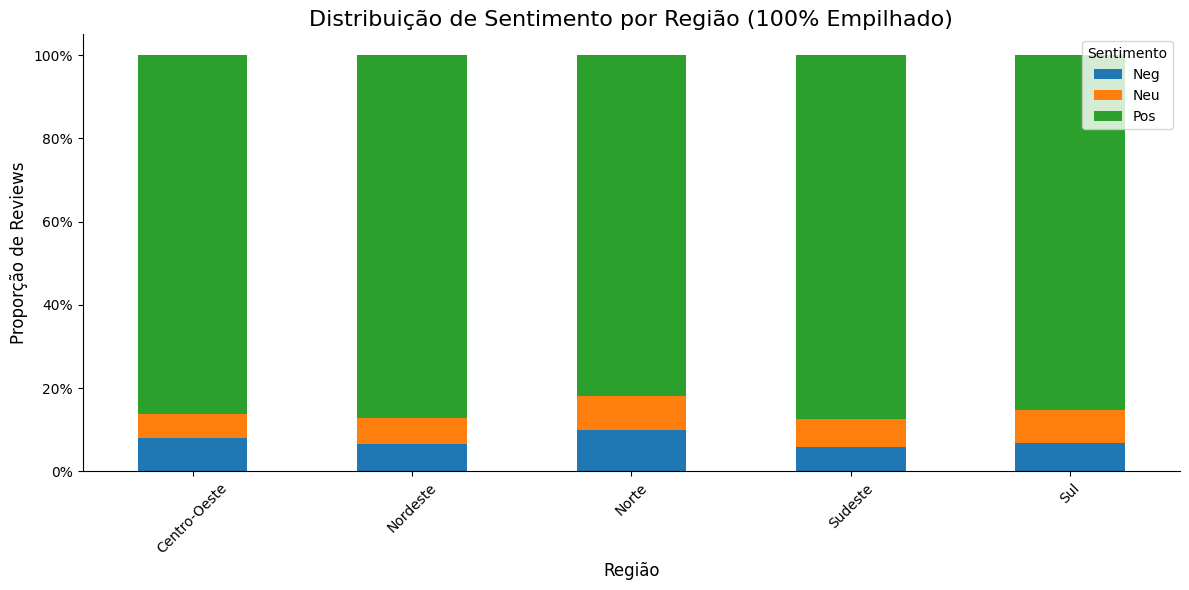

In [ ]:
# Group by region and sentiment, then count occurrences
sentiment_by_region = df_reviews.groupby(['REGIAO_AVALIADOR', 'labels']).size().unstack(fill_value=0)

# Normalize to get percentages
sentiment_by_region_percentage = sentiment_by_region.div(sentiment_by_region.sum(axis=1), axis=0)

# Create a 100% stacked bar chart
ax = sentiment_by_region_percentage.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add titles and labels
plt.title('Distribuição de Sentimento por Região (100% Empilhado)', fontsize=16)
plt.xlabel('Região', fontsize=12)
plt.ylabel('Proporção de Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentimento')

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Clean up the plot
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(df_reviews['REGIAO_AVALIADOR'], df_reviews['labels'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-Square Test for REGIAO_AVALIADOR vs labels")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("\nConclusion: There is a statistically significant association between region and sentiment (p < 0.05).")
else:
    print("\nConclusion: There is no statistically significant association between region and sentiment (p >= 0.05).")

Chi-Square Test for REGIAO_AVALIADOR vs labels
Chi-Square Statistic: 13.114769835688138
P-value: 0.10796128041333951
Degrees of Freedom: 8

Conclusion: There is no statistically significant association between region and sentiment (p >= 0.05).


## Sentiment for gifts vs. non-gifts


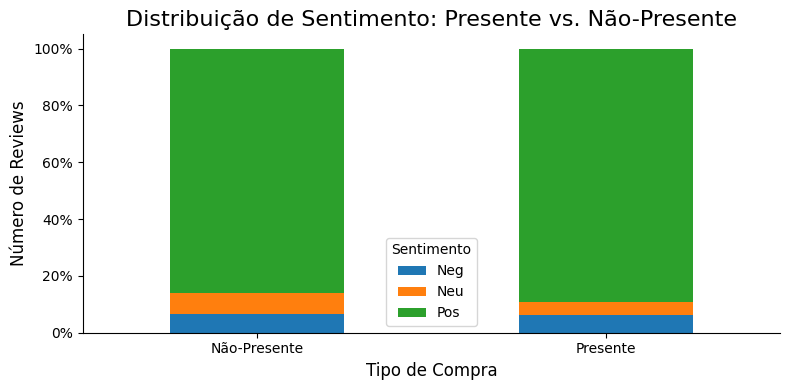

In [ ]:
# Group by region and sentiment, then count occurrences
sentiment_by_region = df_reviews.groupby(['FLG_PRESENTE', 'labels']).size().unstack(fill_value=0)

# Normalize to get percentages
sentiment_by_region_percentage = sentiment_by_region.div(sentiment_by_region.sum(axis=1), axis=0)

# Create a 100% stacked bar chart
ax = sentiment_by_region_percentage.plot(kind='bar', stacked=True, figsize=(8, 4))

# Add titles and labels
plt.title('Distribuição de Sentimento: Presente vs. Não-Presente', fontsize=16)
plt.xlabel('Tipo de Compra', fontsize=12)
plt.ylabel('Número de Reviews', fontsize=12)
plt.legend(title='Sentimento')
plt.xticks(ticks=[0, 1], labels=['Não-Presente', 'Presente'], rotation=0)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Clean up the plot
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
contagem_abs = df_reviews.groupby(['COD_PRODUTO', 'FLG_PRESENTE'])['labels'].value_counts().rename('contagem_absoluta')

proporcao = df_reviews.groupby(['COD_PRODUTO', 'FLG_PRESENTE'])['labels'].value_counts(normalize=True).rename('proporcao')

resultado = pd.concat([contagem_abs, proporcao], axis=1)

resultado

contagem_absoluta  proporcao
COD_PRODUTO FLG_PRESENTE labels                              
111         False        Pos                   277   0.923333
                         Neu                    16   0.053333
                         Neg                     7   0.023333
            True         Pos                   168   1.000000
222         False        Pos                  2423   0.960745
                         Neu                    73   0.028945
                         Neg                    26   0.010309
            True         Pos                  1090   0.882591
                         Neg                    87   0.070445
                         Neu                    58   0.046964
333         False        Pos                   601   0.595639
                         Neg                   221   0.219029
                         Neu                   187   0.185332
            True         Pos                   112   0.823529
                         Neu                    17   0.125000
                         Neg                     7   0.051471

## Word clouds by sentiment

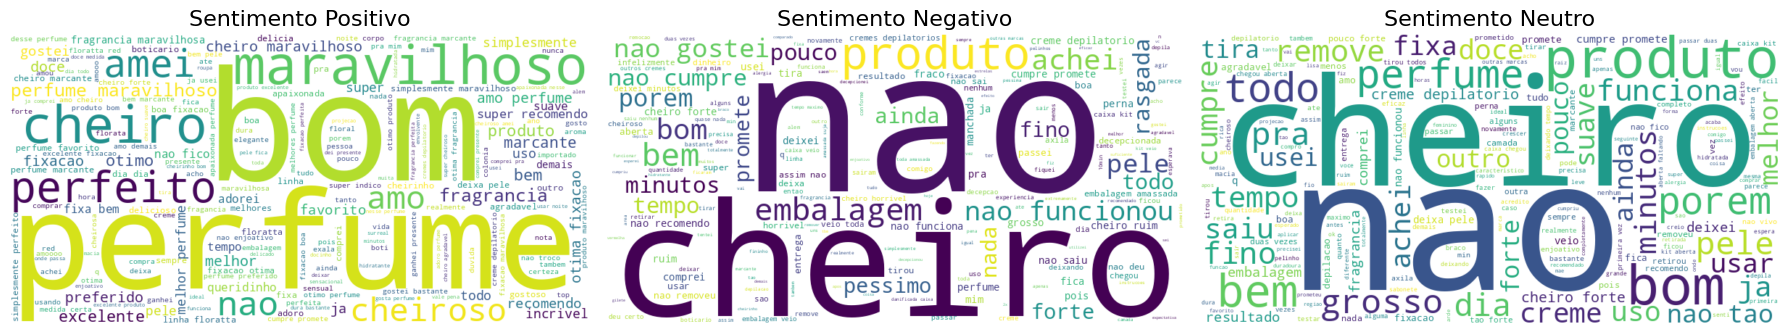

In [ ]:
# Filter reviews by sentiment
positive_reviews = df_reviews[df_reviews['labels'] == 'Pos']['MSG_AVALIACAO']
negative_reviews = df_reviews[df_reviews['labels'] == 'Neg']['MSG_AVALIACAO']
neutral_reviews = df_reviews[df_reviews['labels'] == 'Neu']['MSG_AVALIACAO']

# Combine reviews into single strings
positive_text = " ".join(review for review in positive_reviews)
negative_text = " ".join(review for review in negative_reviews)
neutral_text = " ".join(review for review in neutral_reviews)

# Preprocess the text for each sentiment
positive_text = preprocess_text(positive_text)
negative_text = preprocess_text(negative_text)
neutral_text = preprocess_text(neutral_text)

# Generate word clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
wordcloud_neu = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Display the word clouds
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Sentimento Positivo', fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Sentimento Negativo', fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.title('Sentimento Neutro', fontsize=16)
plt.axis("off")

plt.tight_layout()
plt.show()